# Orange Team CQ#1.7

**Query:** What genes show high phenotypic similarity to the 11 Fanconi Anemia core complex genes (set FA-core)?

## Workflow:


**Input:** NCBIGene identifiers for 11 human FA-core genes

1. Retrieve orthologs of FA-core genes and add to human FA-core set
2. Retrieve phenotype terms associated genes in this set
3. Execute PhenoSim analysis to return ranked list of phenotypically similar genes
4. Select subset of genes meeting some defined threshhold
5. Retrieve human orthologs of all non-human genes in this set

**Output:** GeneSetQ7 (phenotypically similar human genes based on cross-species PhenoSim analysis)

### Contributors:

- Greg Stupp
- Tong Shu Li
- Michael Yu

## Part 1

Retrieve orthologs of FA-core genes and add to human FA-core set.

In [1]:
import requests
from itertools import chain

from tqdm import tqdm
import numpy as np

from scipy.sparse import coo_matrix
import seaborn as sns

%matplotlib inline

### Start with the HGNC symbols for the FA-core genes

In [2]:
fa_genes = [
    'FANCA', 'FANCB', 'FANCC', 'FANCE', 'FANCF',
    'FANCG', 'FANCL', 'FANCM', 'FANCD2', 'FANCI',
    'UBE2T', 'FANCD1', 'BRCA2', 'FANCJ', 'FANCN',
    'FANCO', 'FANCP', 'FANCQ', 'FANCR', 'FANCS',
    'FANCV', 'FANCU'
]

len(fa_genes)

22

### Get Wikidata ids for these HGNC symbols from wikidata using garbanzo

In [3]:
api_url = "http://ec2-52-15-200-208.us-east-2.compute.amazonaws.com/"

c = ' '.join(["HGNCS:" + x for x in fa_genes])
endpoint = "translator/exactMatches/"
params = {'c': c}
r = requests.get(api_url + endpoint, params=params)
qids = [x for x in r.json() if "wd" in x]

In [4]:
qids

['wd:Q17853272',
 'wd:Q18039587',
 'wd:Q17927069',
 'wd:Q17927056',
 'wd:Q17927077',
 'wd:Q18041663',
 'wd:Q18044458',
 'wd:Q18250517',
 'wd:Q17927524',
 'wd:Q17927502',
 'wd:Q18041564',
 'wd:Q17927471']

### Get all orthologs from wikidata using garbanzo

In [5]:
endpoint = 'translator/statements'
params = {'c': qids}
r = requests.get(api_url + endpoint, params=params)
print(r.url)

http://ec2-52-15-200-208.us-east-2.compute.amazonaws.com/translator/statements?c=wd%3AQ17853272&c=wd%3AQ18039587&c=wd%3AQ17927069&c=wd%3AQ17927056&c=wd%3AQ17927077&c=wd%3AQ18041663&c=wd%3AQ18044458&c=wd%3AQ18250517&c=wd%3AQ17927524&c=wd%3AQ17927502&c=wd%3AQ18041564&c=wd%3AQ17927471


In [6]:
ortholog_statements = [x for x in r.json() if x['predicate']['name'] == "ortholog"]
ortholog_qids = set(chain(*[(x['object']['id'], x['subject']['id']) for x in ortholog_statements]))
print(len(ortholog_qids))

35


### Convert to NCBI gene ids

In [7]:
endpoint = "translator/exactMatches/"
params = {'c': ' '.join(ortholog_qids)}
r = requests.get(api_url + endpoint, params=params)
ncbi = [x for x in r.json() if "NCBI" in x]

In [8]:
ncbi

['NCBIGene:29089',
 'NCBIGene:361435',
 'NCBIGene:104806',
 'NCBIGene:72775',
 'NCBIGene:100360594',
 'NCBIGene:60534',
 'NCBIGene:100040608',
 'NCBIGene:67030',
 'NCBIGene:2187',
 'NCBIGene:211651',
 'NCBIGene:691105',
 'NCBIGene:2177',
 'NCBIGene:208836',
 'NCBIGene:501552',
 'NCBIGene:499155',
 'NCBIGene:675',
 'NCBIGene:2189',
 'NCBIGene:305600',
 'NCBIGene:312641',
 'NCBIGene:14087',
 'NCBIGene:309643',
 'NCBIGene:2176',
 'NCBIGene:67196',
 'NCBIGene:2188',
 'NCBIGene:55120',
 'NCBIGene:2178',
 'NCBIGene:2175',
 'NCBIGene:57697',
 'NCBIGene:55215',
 'NCBIGene:360254',
 'NCBIGene:360847',
 'NCBIGene:14088',
 'NCBIGene:24361',
 'NCBIGene:12190',
 'NCBIGene:237211']

## Part 2: Retrieve phenotype terms associated genes in this set

In [9]:
def query(gene_id):
    """Query Monarch to determine the phenotypes associated with a
    NCBI gene id."""
    
    url = "https://api.monarchinitiative.org/api/bioentity/gene/{}/phenotypes/".format(gene_id)
    
    res = requests.get(url)
    
    # assumes that the "objects" response object contains the phenotypes
    return res.json()["objects"]

In [10]:
phenos = {}
for gene_id in tqdm(ncbi):
    res = query(gene_id)
    phenos[gene_id] = res

100%|██████████| 35/35 [00:31<00:00,  1.47it/s]


## Part 3: Execute PhenoSim analysis to return ranked list of phenotypically similar genes

### Get list of all human genes (NCBI Gene ids)

In [11]:
with open('human_genes.txt') as f:
    all_human_genes = set(f.read().splitlines())

In [12]:
len(all_human_genes)

60284

### Create a similarity matrix of human_genes by non_human_genes, based on a Jaccard similarity of the associated phenotype sets

In [13]:
all_phenotype = sorted(np.unique(list(chain(*phenos.values()))))

phenotype_idx = {b : a for a, b in enumerate(all_phenotype)}
all_gene = sorted(phenos.keys())
gene_idx = {b : a for a, b in enumerate(all_gene)}

In [14]:
human_genes = sorted([x for x in phenos.keys() if x.split('NCBIGene:')[1] in all_human_genes])
human_genes_idx = {b : a for a, b in enumerate(human_genes)}
non_human_genes = [x for x in phenos.keys() if x.split('NCBIGene:')[1] not in all_human_genes]
non_human_genes_idx = {b : a for a, b in enumerate(non_human_genes)}

In [15]:
phenos_set = {a : set(b) for a, b in phenos.items()}
def get_similarity(x,y):
    x_set = phenos_set[x]
    y_set = phenos_set[y]
    return len(x_set & y_set) / float(len(x_set | y_set))

data_ij = [(get_similarity(x,y), human_genes_idx[x], non_human_genes_idx[y]) for x in human_genes for y in non_human_genes]
data, i_list, j_list = zip(*data_ij)
data, i_list, j_list = np.array(data), np.array(i_list), np.array(j_list)
g2g = coo_matrix((data, (i_list, j_list)),
                  shape=(len(human_genes), len(non_human_genes)))
g2g = g2g.toarray()

In [16]:
g2g.min(0)

array([ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.00409836,  0.01098901,  0.01485149,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.00420168,  0.        ,
        0.        ,  0.        ,  0.        ,  0.00381679,  0.        ,
        0.        ,  0.        ,  0.01153846])

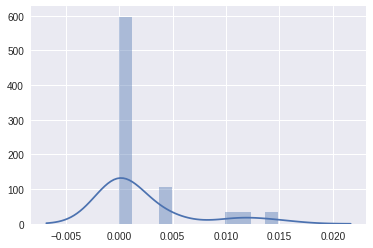

In [17]:
sns.distplot(g2g.min(0))

### Identify all non-human-genes that have a non-zero Jaccard similarity with at least one of the FA human genes

In [18]:
np.array(non_human_genes)[g2g.min(0) > 0]

array(['NCBIGene:60534', 'NCBIGene:211651', 'NCBIGene:14087',
       'NCBIGene:104806', 'NCBIGene:14088', 'NCBIGene:12190'], 
      dtype='<U18')

## Step 5: Retrieve human orthologs of all non-human genes in this set

In [19]:
nonhuman = list(np.array(non_human_genes)[g2g.min(0) > 0])

In [20]:
def query_nonhuman(gene_id):
    """Query Monarch to determine the human orthologs of a gene."""
    
    url = "https://api.monarchinitiative.org/api/bioentity/gene/{}/homologs/".format(gene_id)
    params = {
        "fetch_objects": True,
        "rows": 20,
        "homolog_taxon": "NCBITaxon:9606" # humans
    }
    res = requests.get(url, params=params)
    
    return res.json()["objects"]

In [21]:
orthologs = {
    gene_id: query_nonhuman(gene_id)
    for gene_id in tqdm(nonhuman)
}

100%|██████████| 6/6 [00:03<00:00,  1.89it/s]


In [22]:
orthologs

{'NCBIGene:104806': ['NCBIGene:57697'],
 'NCBIGene:12190': ['NCBIGene:675'],
 'NCBIGene:14087': ['NCBIGene:2175'],
 'NCBIGene:14088': ['NCBIGene:2176'],
 'NCBIGene:211651': ['NCBIGene:2177'],
 'NCBIGene:60534': ['NCBIGene:2189']}

## Output: GeneSetQ7 (phenotypically similar human genes based on cross-species PhenoSim analysis)

In [23]:
final_genes = [
    v[0]
    for k, v in orthologs.items()
]

In [24]:
final_genes

['NCBIGene:2189',
 'NCBIGene:2176',
 'NCBIGene:2177',
 'NCBIGene:2175',
 'NCBIGene:675',
 'NCBIGene:57697']